# Skincare Recommendations
This project is a skincare recommendation system aimed at assisting users in finding personalized skincare products based on their specific needs and preferences. The system utilizes machine learning techniques to analyze user input and provide tailored recommendations, taking into account factors such as skin type, concerns, and desired outcomes. By leveraging a vast database of skincare products on Sephora and Amazon and knowledge, the system aims to enhance the skincare journey for individuals by offering informed and reliable suggestions

The Skincare recommendations has three models. All three models can be found in a **Dash web app**.
- Model 1 is based on user feature similarity: Recommender that uses the customer features only to recommend the products
- Model 2 is a content-based recommendations: Recommends products using similarity between their ingredients
- Mode 3 is a hybrid model (using library LightFM). This is best for business use: customer service represintatives can type in a unique user id and get a list of products recommended to that user, which, for example, can be emailed to that customer.

**A note on data acquisition and feature engineering**: We mostly scraped Sephora.com and Amazon.com using selenium webdriver and got two dataframes: user data and product data. They were merged together on unique user id, cleaned, which resulted in a big dataframe with the following columns: 'Username', 'Skin_Tone', 'Skin_Type', 'Eye_Color', 'Hair_Color','Rating_Stars', 'Review', 'Product', 'Brand', 'Price', 'Rating','Ingredients', 'Combination', 'Dry', 'Normal', 'Oily', 'Sensitive','Category', 'Product_Url', 'User_id', 'Product_id','Ingredients_Cleaned', 'Review_Cleaned', 'Good_Stuff', 'Ing_Tfidf'.

<img src='https://assets.vogue.in/photos/5ce425024a30b34f3112cab9/master/pass/These-are-the-skincare-ingredients-you-should-look-for-by-your-skin-type.jpg' width=1000/>

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.metrics.pairwise import cosine_similarity


from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer



from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

import warnings; warnings.simplefilter('ignore')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
df = pd.read_csv('skindataall.csv', index_col=[0])

In [ ]:
df.head()

,Username,Skin_Tone,Skin_Type,Eye_Color,Hair_Color,Rating_Stars,Review,Product,Brand,Price,...,Oily,Sensitive,Category,Product_Url,User_id,Product_id,Ingredients_Cleaned,Review_Cleaned,Good_Stuff,Ing_Tfidf
0,allyp3,Medium,Combination,Brown,Brunette,5,This is hands down the best cleanser I’ve ever...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,3420,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['hand', 'best', 'cleanser', 'ever', 'used', '...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
1,PatTea,Medium,Combination,Brown,Red,1,Unfortunately this doesn’t work for everyone. ...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,2483,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['unfortunately', 'work', 'everyone', 'used', ...",0,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
2,Sabi1991,No data,No data,No data,No data,5,My favorite cleanser!! i love the packaging on...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,2715,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['favorite', 'cleanser', 'love', 'packaging', ...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
3,happyface2,Fair,Dry,Blue,Blonde,5,I love all things Youth To The People! This cl...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,4497,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['love', 'thing', 'youth', 'people', 'cleanser...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
4,kimkix34,Fair,Normal,Green,Blonde,5,I had a trial size of this and was obsessed. M...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,5017,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['trial', 'size', 'wa', 'obsessed', 'skin', 'f...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."


# EDA and Data Visualizations

<Axes: xlabel='Skin_Tone'>

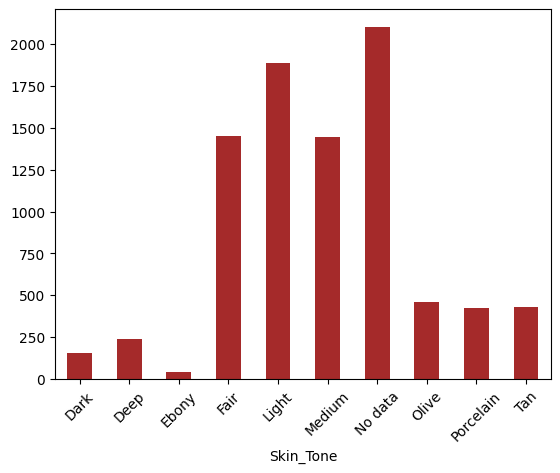

In [ ]:
skintone_stats = df.groupby('Skin_Tone')['Username'].count()
skintone_stats.plot.bar(color = 'brown', rot=45)

<Axes: xlabel='Skin_Type'>

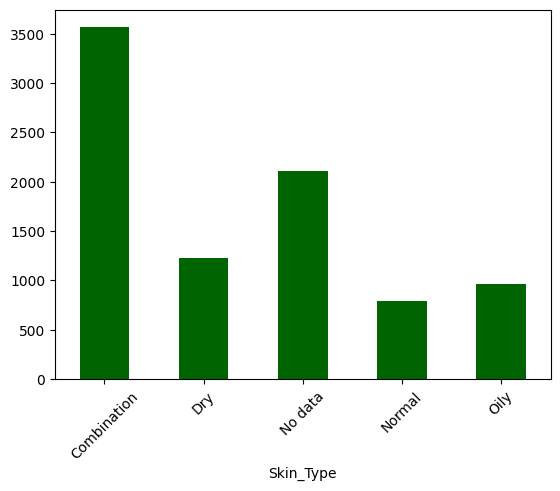

In [ ]:
skintype_stats = df.groupby('Skin_Type')['Username'].count()
skintype_stats.plot.bar(color = 'darkgreen', rot=45)

<Axes: xlabel='Eye_Color'>

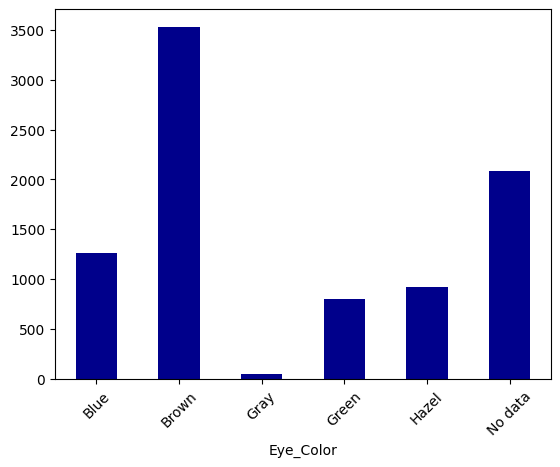

In [ ]:
eyecolor_stats = df.groupby('Eye_Color')['Username'].count()
eyecolor_stats.plot.bar(color = 'darkblue', rot=45)

<Axes: xlabel='Hair_Color'>

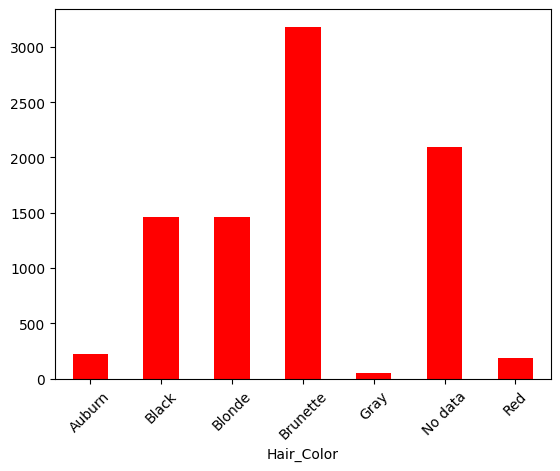

In [ ]:
haircolor_stats = df.groupby('Hair_Color')['Username'].count()
haircolor_stats.plot.bar(color = 'red', rot=45)

<Axes: xlabel='Rating_Stars'>

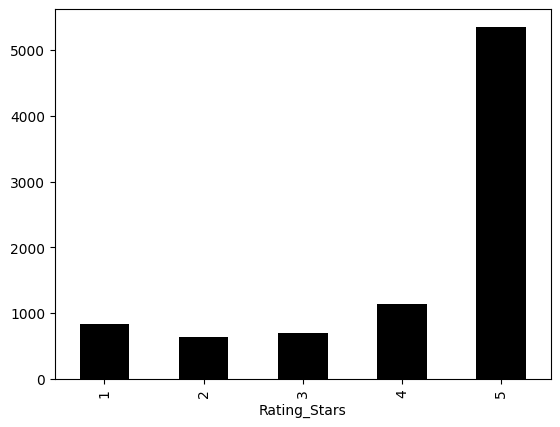

In [ ]:
rating_stats = df.groupby('Rating_Stars')['Username'].count()
rating_stats.plot.bar(color = 'black')

As we can see on the graph above, the ratings are unevenly distributed. One may expect to see more balanced ratings, or more 1-star reviews, but in reality, 5-star is a dominant class. This means that Sephora customers mostly write reviews when they are happy with the product. This may cause some problems in building a recommendation system, so the threshold should be 'greater than 4' and '4 or less'. We only want to recommend products that a user will rate with 5 stars.

# Just for fun: Markov Chain neural net for language generator

In [ ]:
!pip install markovify

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.8 MB/s eta 0:00:00
  Created wheel for markovify: filename=markovify-0.9.4-py3-none-any.whl size=18608 sha256=7c78ec09c411be351676ac345fbc0ea9e75be70c607a74b25112c50f3919ee24
  Stored in directory: /root/.cache/pip/wheels/ca/8c/c5/41413e24c484f883a100c63ca7b3b0362b7c6f6eb6d7c9cc7f
Successfully built markovify


In [ ]:
import markovify
import string

In [ ]:
def no_punct(string):
    no_punct_string = re.sub(r'[^\w\s]', '', string)
    return no_punct_string

In [ ]:
df['Review'] = df.apply(lambda row: no_punct(row['Review']), axis=1)

In [ ]:
text_model = markovify.NewlineText(df.Review, state_size = 2)

In [ ]:
for i in range(3):
    print(text_model.make_sentence())

The best scrub out there and they last me about clinique years ago and found out today that this toner I have is with this I think
I was skeptical about this product is amazing when first applied Instant results However my acne after a few years and loved it but toners arent necessary for my face looks noticeably brighter totally worth it not harsh on my second one I will not get into deep pores and my makeup plus it comes out on your face feeling and looking Never makes my skin cleared up my face was for about 2 weeks I love this kind of basic in every time I travel all over by the scent because I normally dont leave any residue behind It also doesnt make any application more glowy face I have dry skin Smells great smooth skin and suffer from cystic to now Worked better than any product that it was bad but not overwhelming It leaves a slight difference I would give it a go to I have to rinse again just a few uses to kick in so many different moisturizers in my skincare regime Btw I ha

# NLP: wordclouds and classification

In [ ]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
negative_df = df[df.Rating_Stars <= 4]
positive_df = df[df.Rating_Stars > 4]
negative = " ".join(review for review in negative_df.Review)
positive = " ".join(review for review in positive_df.Review)

In [ ]:
stopwords = set(STOPWORDS)
stopwords.update(['read', 'more', 'product'])

In [ ]:
def generate_wordcloud(data):
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(data)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

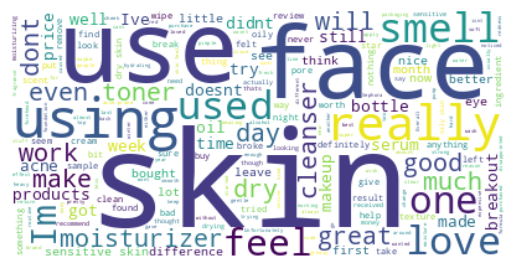

In [ ]:
generate_wordcloud(negative)

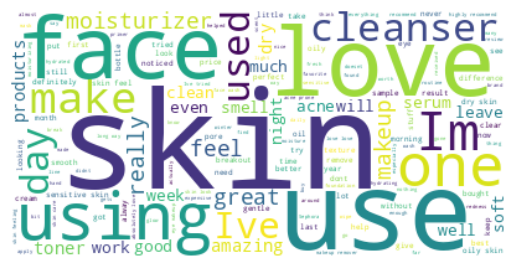

In [ ]:
generate_wordcloud(positive)

If you carefully look at the wordcloud of the negative reviews, you can see that a lot of people complain about the smell of the skincare product!

Now let's analyze the indredients of the skincare products. Knowing very little about chemistry, can I distinguish the items between categories, such as serum, moisturizers, cleansers, etc..?

In [ ]:
moist_df = df[df.Category == 'Moisturizer']
cleanse_df = df[df.Category == 'Cleanser']
mask_df = df[df.Category == 'Face Mask']
treat_df = df[df.Category == 'Treatment']

In [ ]:
moist = " ".join(ing for ing in moist_df.Ingredients)
cleanse = " ".join(ing for ing in cleanse_df.Ingredients)
mask = " ".join(ing for ing in mask_df.Ingredients)
treat = " ".join(ing for ing in treat_df.Ingredients)

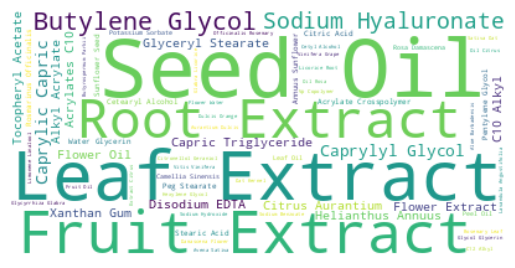

In [ ]:
generate_wordcloud(moist)

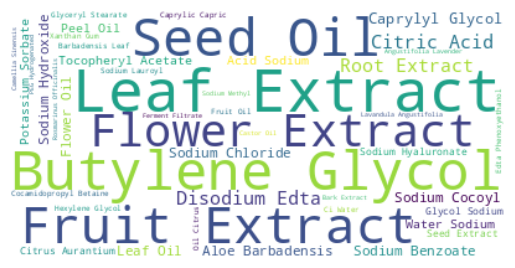

In [ ]:
generate_wordcloud(cleanse)

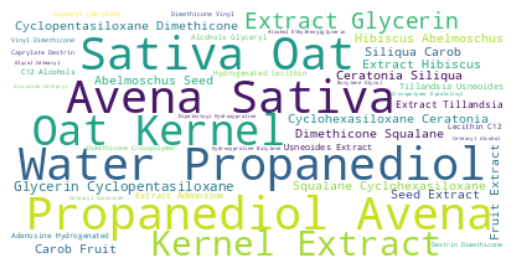

In [ ]:
generate_wordcloud(mask)

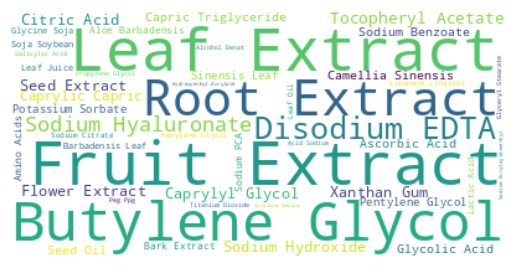

In [ ]:
generate_wordcloud(treat)

Let's build a classification model to distinguish the products.

In [ ]:
X = df.Ingredients
y = df.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [ ]:
categories = ['Moisturizer', 'Cleanser', 'Face Mask', 'Treatment']

In [ ]:
#Naive Bayes
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))

accuracy 0.9653259361997226
              precision    recall  f1-score   support

 Moisturizer       0.96      0.99      0.98      1031
    Cleanser       0.00      0.00      0.00         9
   Face Mask       0.99      0.96      0.98       649
   Treatment       0.94      0.92      0.93       474

    accuracy                           0.97      2163
   macro avg       0.72      0.72      0.72      2163
weighted avg       0.96      0.97      0.96      2163



In [ ]:
#Logistic Regression
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))

accuracy 0.9833564493758669
              precision    recall  f1-score   support

 Moisturizer       0.99      0.97      0.98      1031
    Cleanser       1.00      1.00      1.00         9
   Face Mask       0.97      1.00      0.98       649
   Treatment       0.98      0.99      0.98       474

    accuracy                           0.98      2163
   macro avg       0.99      0.99      0.99      2163
weighted avg       0.98      0.98      0.98      2163



In [ ]:
#SVG with SGD
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))

accuracy 0.9754969949144706
              precision    recall  f1-score   support

 Moisturizer       0.99      0.97      0.98      1031
    Cleanser       1.00      1.00      1.00         9
   Face Mask       0.96      1.00      0.98       649
   Treatment       0.97      0.96      0.96       474

    accuracy                           0.98      2163
   macro avg       0.98      0.98      0.98      2163
weighted avg       0.98      0.98      0.98      2163



# Latent Dirichlet Allocation

Now that we know that different skincare categories are distinguishable, it would be interesting to use unsupervised clustering to figure out how the ingredients would group naturally.

In [ ]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 6.7 MB/s eta 0:00:00


In [ ]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
ing_raw = df.Ingredients

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5,
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(ing_raw)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(ing_raw)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lda_tf = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tfidf.fit(dtm_tfidf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(n_components=4, random_state=0)

In [ ]:
pyLDAvis.lda_model.prepare(lda_tf, dtm_tf, tf_vectorizer)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.045307  0.098513       1        1  29.719774
1     -0.054946  0.090008       2        1  27.803118
0     -0.100708 -0.156776       3        1  21.867311
2      0.200961 -0.031746       4        1  20.609796, topic_info=             Term         Freq        Total Category  logprob  loglift
1079         leaf  8675.000000  8675.000000  Default  30.0000  30.0000
1761         seed  6742.000000  6742.000000  Default  29.0000  29.0000
807     gluconate  1376.000000  1376.000000  Default  28.0000  28.0000
166   azadirachta   621.000000   621.000000  Default  27.0000  27.0000
1193        melia   621.000000   621.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1961   tocopherol   526.856395  2118.985003   Topic4  -5.1719   0.1876
287      butylene   607.304202  4022.323237   Topic4  -5.0298  -0.3112
1741       sativa   439.746965  1585.333768   Topic4  -5.3526   0.2971
1441          peg   508.025958  5863.756541   Topic4  -5.2083  -0.8666
935     hydroxide   451.529209  2435.819494   Topic4  -5.3262  -0.1060

[329 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
8         1  0.994914     acer
12        1  0.284459  acetate
12        2  0.344755  acetate
12        3  0.221732  acetate
12        4  0.149280  acetate
...     ...       ...      ...
2087      4  0.021454  xanthan
2091      2  0.991347  xylitol
2094      2  0.145028   yellow
2094      3  0.652624   yellow
2094      4  0.202364   yellow

[555 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

## Quality and effectiveness check

What makes a user give a five star rating to a product? Probably visible results of using it. If a woman buys a cream that erases her wrinkes after a week of using it, it is expected that she will go to the website and write a positive review. But what makes a high quality product? Define not the package -- it's ingredients that work! Can we predict whether or not the product will get a 5 star rating just using its ingredient list?

In [ ]:
X1 = df.Ingredients
y1 = df.Good_Stuff
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.25, random_state = 42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
cat = ['1', '0']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Naive Bayes
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train1, y_train1)

y_pred1 = nb.predict(X_test1)

print('accuracy %s' % accuracy_score(y_pred1, y_test1))
print(classification_report(y_test1, y_pred1, target_names=cat))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


accuracy 0.5973185390661119
              precision    recall  f1-score   support

           1       0.48      0.25      0.33       856
           0       0.63      0.82      0.71      1307

    accuracy                           0.60      2163
   macro avg       0.56      0.54      0.52      2163
weighted avg       0.57      0.60      0.56      2163



In [ ]:
#Logistic Regression
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train1, y_train1)


y_pred1 = logreg.predict(X_test1)

print('accuracy %s' % accuracy_score(y_pred1, y_test1))
print(classification_report(y_test1, y_pred1, target_names=cat))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


accuracy 0.6047156726768377
              precision    recall  f1-score   support

           1       0.50      0.26      0.34       856
           0       0.63      0.83      0.72      1307

    accuracy                           0.60      2163
   macro avg       0.57      0.54      0.53      2163
weighted avg       0.58      0.60      0.57      2163



In [ ]:
#SVG with SGD
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train1, y_train1)

y_pred1 = sgd.predict(X_test1)

print('accuracy %s' % accuracy_score(y_pred1, y_test1))
print(classification_report(y_test1, y_pred1, target_names=cat))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


accuracy 0.6116504854368932
              precision    recall  f1-score   support

           1       0.61      0.05      0.09       856
           0       0.61      0.98      0.75      1307

    accuracy                           0.61      2163
   macro avg       0.61      0.51      0.42      2163
weighted avg       0.61      0.61      0.49      2163



Surprisingly, none of the models could predict the quality/effectiveness with good accuracy. This can be easily explained by the fact that a lot of people remove one star from the rating because of the high price. We want to keep this in mind when we are recommending the products.

# Modeling recommenders

We begin the modeling process with SVD from Surprise.

In [ ]:
!pip install scikit-surprise


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162995 sha256=4cebf6b58b803cc1b82c5a377844d41abc873a1b213fba76feb15d358ec1f57a
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split as tts
from surprise.model_selection import RandomizedSearchCV

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data = df[['User_id', 'Product_id', 'Rating']]
reader = Reader(line_format='user item rating', sep=',')
data = Dataset.load_from_df(data, reader=reader)

trainset, testset = tts(data, test_size=.2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
svd = SVD()
svd.fit(trainset)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
predictions = svd.test(testset)
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 0.1230
MAE:  0.0681


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.06812477551452122

Predictions are off by 0.1 stars!

## Recommender that uses the customer features only to recommend the products

In [ ]:
def recommend_products_by_user_features(skintone, skintype, eyecolor, haircolor, percentile=0.85):
    ddf = df[(df['Skin_Tone'] == skintone) & (df['Hair_Color'] == haircolor) & (df['Skin_Type'] == skintype) & (df['Eye_Color'] == eyecolor)]

    recommendations = ddf[(ddf['Rating_Stars'].notnull())][['Rating_Stars', 'Product_Url', 'Product']]
    recommendations = recommendations.sort_values('Rating_Stars', ascending=False).head(10)

    print('Based on your features, these are the top products for you:')
    return recommendations

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
recommend_products_by_user_features('Light', 'Combination', 'Green', 'Brunette')

Based on your features, these are the top products for you:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Rating_Stars,Product_Url,Product
349,5,https://www.sephora.com/product/bi-facil-doubl...,Bi-Facil Double-Action Eye Makeup Remover
1977,5,https://www.sephora.com/product/ultimate-mirac...,Ultimate Miracle Worker Multi-Rejuvenating Cre...
2800,5,https://www.sephora.com/product/aqua-bomb-slee...,Aqua Bomb Sleeping Mask
2918,5,https://www.sephora.com/product/vitamin-c-anti...,Vitamin Nectar Antioxidant Face Mist
2944,5,https://www.sephora.com/product/peat-miracle-r...,Peat Miracle Revital Cream
2998,5,https://www.sephora.com/product/gold-camellia-...,Gold Camellia Beauty Oil
350,5,https://www.sephora.com/product/bi-facil-doubl...,Bi-Facil Double-Action Eye Makeup Remover
3525,5,https://www.sephora.com/product/the-cleansing-...,The Cleansing Foam
3999,5,https://www.sephora.com/product/clean-bee-ultr...,Clean Bee Ultra Gentle Facial Cleanser
4069,5,https://www.sephora.com/product/time-release-a...,Time Release Acne Cleanser


## Collaborative filtering with Lightfm

In [ ]:
!pip install lightfm


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808333 sha256=346885a5d1fedcf46cc543f18353c00d8f6ce255bfa8754d86e9b01ae9745134
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [ ]:
from scipy import sparse
from lightfm import LightFM
from sklearn.metrics.pairwise import cosine_similarity
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k,recall_at_k

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def create_interaction_matrix(df, user_col, item_col, rating_col, norm= False, threshold = None):
    interactions = df.groupby([user_col, item_col])[rating_col].sum().unstack().reset_index().fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
interaction_matrix = create_interaction_matrix(df=df, user_col='User_id', item_col = 'Product_id', rating_col='Rating_Stars')
interaction_matrix.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Product_id,0,1,2,3,4,5,6,7,8,9,...,305,306,307,308,309,310,311,312,313,314
User_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def runMF(interactions, n_components=30, loss='warp', k=15, epoch=30,n_jobs = 4):
    x = sparse.csr_matrix(interactions.values)
    model = LightFM(no_components= n_components, loss=loss,k=k)
    model.fit(x,epochs=epoch,num_threads = n_jobs)
    train_auc = auc_score(model, x, num_threads=n_jobs).mean()
    print('Collaborative filtering AUC: %s' % train_auc)
    print("Train precision: %.4f" % precision_at_k(model, x, k=k,num_threads=n_jobs).mean())

    return model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
mf_model = runMF(interactions = interaction_matrix,
                 n_components = 30,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Collaborative filtering AUC: 0.9999995
Train precision: 0.0729


In [ ]:
def create_user_dict(interactions):
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
user_dict = create_user_dict(interaction_matrix)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def create_item_dict(df, id_col, name_col):
    item_dict ={}
    for i in df.index:
        item_dict[(df.loc[i, id_col])] = df.loc[i, name_col]
    return item_dict

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
product_dict = create_item_dict(df = df, id_col = 'Product_id', name_col = 'Product')
print(product_dict)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{157: 'Superfood Antioxidant Cleanser', 65: 'Cleansing & Exfoliating Wipes', 210: 'Purity Made Simple Cleanser', 35: 'Beste™ No. 9 Jelly Cleanser', 196: 'The Rice Polish Foaming Enzyme Powder', 229: 'Rose Deep Hydration Facial Toner', 255: 'Take The Day Off Cleansing Balm', 36: 'Bi-Facil Double-Action Eye Makeup Remover', 29: 'Balancing Force™ Oil Control Toner', 32: 'Beauty Elixir', 310: 'Waterproof Eye Makeup Remover', 257: 'Take The Day Off Makeup Remover For Lids, Lashes & Lips', 117: 'Facial Cotton', 113: 'ExfoliKate® Cleanser Daily Foaming Wash', 57: 'Checks and Balances™ Frothy Face Wash', 52: 'Calendula Herbal Extract Alcohol Free Toner', 258: 'The Clean Truth™ Foaming Cleanser', 278: 'Transforming Walnut Scrub', 144: 'Greek Yoghurt Foaming Cream Cleanser', 81: 'CoQ-10 Toner', 48: 'Brightening Cleanser', 271: 'The True Cream Aqua Bomb', 268: 'The Moisturizing Soft Cream', 272: 'The True Cream Moisturizing Bomb', 79: 'COMPLEXION RESCUE™ Tinted Moisturizer Broad Spectrum SPF 30',

In [ ]:
def sample_recommendation_user(model, interactions, user_id, user_dict,
                               item_dict, threshold = 0, nrec_items = 10, show = True):

    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))

    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    #print(scores)
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    #print(return_score_list)
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
cha
    if show == True:
        print(scores)

    return scores

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rec_list = sample_recommendation_user(model = mf_model,
                                      interactions = interaction_matrix,
                                      user_id = 3000,
                                      user_dict = user_dict,
                                      item_dict = product_dict,
                                      threshold = 4,
                                      nrec_items = 10,
                                      show = True)

['Squalane + Vitamin C Rose Oil', 'White Lucent Brightening Cleansing Foam', 'The Method: Cleanse', 'Rapid Collagen Infusion', 'The Clean Truth™ Foaming Cleanser', 'Alpha Beta® Universal Daily Peel', '3% Glycolic Solutions Cleanser', 'Squalane + Omega Repair Cream', 'Bi-Facil Double-Action Eye Makeup Remover', 'Pore-Balance™ Facial Sauna Scrub']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Content-based recommendations using Ingredients of the product

In [ ]:
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_cont = df[['Product', 'Product_id', 'Ingredients', 'Product_Url', 'Ing_Tfidf', 'Rating']]
df_cont.drop_duplicates(inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df_cont['Ingredients'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.03602058 0.01675374 ... 0.04421634 0.01083992 0.05508547]
 [0.03602058 1.         0.03234385 ... 0.04246818 0.01718575 0.05482465]
 [0.01675374 0.03234385 1.         ... 0.01722917 0.04359774 0.03338317]
 ...
 [0.04421634 0.04246818 0.01722917 ... 1.         0.02533046 0.05428158]
 [0.01083992 0.01718575 0.04359774 ... 0.02533046 1.         0.05768039]
 [0.05508547 0.05482465 0.03338317 ... 0.05428158 0.05768039 1.        ]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_cont = df_cont.reset_index(drop=True)
titles = df_cont[['Product', 'Ing_Tfidf', 'Rating',]]
indices = pd.Series(df_cont.index, index=df_cont['Product'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# def content_recommendations(product):
#     idx = indices[product]
#     sim_scores = list(enumerate(cosine_sim[idx]))
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     sim_scores = sim_scores[1:11]
#     product_indices = [i[0] for i in sim_scores]
#     return titles.iloc[product_indices]

def content_recommendations(product):
    idx = indices[product]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    product_indices = [i[0] for i in sim_scores]

    # Tính toán khoảng cách cosine
    cosine_dist = 1 - cosine_sim

    # Tạo DataFrame cho các sản phẩm được gợi ý
    recommendations = titles.iloc[product_indices].reset_index()
    recommendations['Cosine Distance'] = [cosine_dist[idx][i] for i in product_indices]

    return recommendations





/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(content_recommendations('Superfood Antioxidant Cleanser'))
# ('The Rice Polish Foaming Enzyme Powder')

   index                                      Product  \
0    279  Superfood Firm and Brighten Vitamin C Serum   
1    160          Deep Dive™ Glycolic Facial Cleanser   
2    161            Jasmine Green Tea Balancing Toner   
3    167                  8% Glycolic Solutions Toner   
4     54          Pink Cloud Rosewater Moisture Crème   
5    127       Clean Bee Ultra Gentle Facial Cleanser   
6    208                      Hydrating Essence Toner   
7    269               Max Complexion Correction Pads   
8    187                       Problem Solution Toner   
9    108                      Purifying Cleansing Gel   

                                           Ing_Tfidf  Rating  Cosine Distance  
0  lactic, acid, citric, acid, malic, acid, glyce...     3.9         0.415741  
1  kaolin, glycerin, sodium, methyl, cocoyl, taur...     4.6         0.755817  
2  jasminum, officinale, jasmine, flower, hamamel...     4.2         0.812712  
3  glycolic, acid, alcohol, denat, methyl, glucet...

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


These recommendations actually make a lot of sense. I have tested it on the product that I used and loved, and it spits out the names that I also enjoy!